Analysis of measurement frequency content
====================================

We want to analyze freqyencies of the 338 different measurement variables. That is, we want to see if we can group or cluster the variables based on the frequency of change. Each variable $x_i$ is logged when the measurement value changes with some interval $\Delta x_i$.

For a 6 hour measurment interval we have a very sparse matrix with 339 columns and over 400,000 rows. If some variables are logged every $1000^{th}$ row, while others are logged every $10^{th}$ row, we want to analyze them seperately.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import timeit

import filehandler as fh
import datahandler as dh

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

Setting important paths and loading the filenames of all the .zip files cointaining data.

In [54]:
zip_path = '../data/zipped/'
unzip_path = '../data/unzipped/'
csv_path = '../data/unzipped/KMFILES/'
freq_path = '../data/frequency/'
list_path = '../data/'
listfile = 'signal_list.h5'
ext = '*.zip'
zipfiles = fh.filesInDir(zip_path,ext)

We now load $n$ random zip files and extract the csv files.

In [3]:
n = 5
np.random.seed(0)

zipfiles_c = zipfiles
files = []

start = timeit.default_timer()
for i in range(n):
    j = np.random.randint(0, len(zipfiles_c))
    files.append(zipfiles_c.pop(j))
    print files[i]

fh.unzipFiles(files, zip_path, unzip_path)
stop = timeit.default_timer()
print ('Time used unzipping ' +str(n)+' file(s): '+ str(stop - start))+' seconds'

DAILY_FINAL_Timeseries_Recorded_From_06_27_2014T16_31_00_To_06_27_2014T22_31_00.zip
DAILY_FINAL_Timeseries_Recorded_From_05_26_2015T22_31_00_To_05_27_2015T4_31_00.zip
DAILY_FINAL_Timeseries_Recorded_From_09_06_2015T22_31_00_To_09_07_2015T4_31_00.zip
DAILY_FINAL_Timeseries_Recorded_From_07_16_2014T22_31_00_To_07_17_2014T4_31_00.zip
DAILY_FINAL_Timeseries_Recorded_From_07_07_2014T22_31_00_To_07_08_2014T4_31_00.zip

Unzipping 5 file(s) to D:\Erling\NTNU\Prosjektoppgave\bigdata\data\unzipped...
Done unzipping

Time used unzipping 5 file(s): 28.8289177606 seconds


Now we want to load the $n$ selected files and analyze the frequency content of the different variables and saving the result to a .h5 file.

In [4]:
dts = []
freq_dfs = [] 
start = timeit.default_timer()
for f in files:
    # Loading dataframe
    f = f[0:-3]+'csv'
    df = fh.loadDataCSV(csv_path, f)
    print 'Loaded dataframe from '+f
    
    # Converting boolean values to 1 or 0 to get rid of 'object' columns
    obcols = dh.getObjectCols(df)
    df[obcols] = dh.replaceBoolWithInt(df[obcols])
    print '\tConverted boolean values to int'
    
    # Computing variable frequencies
    (freq_df, dt) = dh.getColFreqs(df)
    print '\tCalculated frequencies'
    
    # Saving the frqeuncy dataframe as a .h5 file
    freq_df.to_hdf('../data/frequency/'+f[0:-4]+'_FREQ.h5', 'table')
    freq_dfs.append(freq_df)
    dts.append(dt)
    del df

stop = timeit.default_timer()
print ('Time used loading and analyzing ' +str(n)+' file(s): '+ str(stop - start))+' seconds'

D:\Erling\Programmer\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2825: DtypeWarning: Columns (140,168,171,172,173,174,180,181,182,183,184,185,186,187,188,272,273,274,275,276,277,285,286,287,288,289,290,291,292,293,294,297) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Loaded dataframe from DAILY_FINAL_Timeseries_Recorded_From_06_27_2014T16_31_00_To_06_27_2014T22_31_00.csv
	Converted boolean values to int
	Calculated frequencies
Loaded dataframe from DAILY_FINAL_Timeseries_Recorded_From_05_26_2015T22_31_00_To_05_27_2015T4_31_00.csv
	Converted boolean values to int
	Calculated frequencies
Loaded dataframe from DAILY_FINAL_Timeseries_Recorded_From_09_06_2015T22_31_00_To_09_07_2015T4_31_00.csv
	Converted boolean values to int
	Calculated frequencies
Loaded dataframe from DAILY_FINAL_Timeseries_Recorded_From_07_16_2014T22_31_00_To_07_17_2014T4_31_00.csv
	Converted boolean values to int
	Calculated frequencies
Loaded dataframe from DAILY_FINAL_Timeseries_Recorded_From_07_07_2014T22_31_00_To_07_08_2014T4_31_00.csv
	Converted boolean values to int
	Calculated frequencies
Time used loading and analyzing 5 file(s): 707.809826613 seconds


Loading a dataframe cointaining information about all the variables.

In [74]:
sl = fh.loadDataH5(list_path, listfile)

# Creating labels with names for each variable
df = freq_dfs[0]
labels = np.array(df.index).astype(str)
systems = np.array(df.index).astype(str)
tag_map = {'Start':'.01', 'Stop':'.02', 'OutRunning':'.03', 'Meas1':'', 'B4':'', 'Out':'', 'ProMeas':'', 'OutMeas':'', 'OutPosition':'.01'}

for i,l in enumerate(labels):
    tag = l.split('/',2)
    if len(tag)>1:
        tag_id = tag[1]
        tag = tag[0]+tag_map[tag[1]]
    elif tag[0] == 'nan':
        tag = np.nan
    labels[i] = tag
    
    try:
        labels[i] = sl.loc[tag, 'RDS Name']
        systems[i] = sl.loc[tag, 'RDS Location']
    except KeyError:
        systems[i] = 'N/A'

# Inserting Name and System columns in dataframes and saving
for f in files:
    f = f[0:-4]+'_FREQ.h5'
    df = pd.read_hdf(freq_path+f, 'table')
    df.insert(loc = 2, column = 'Name', value = labels)
    df.insert(loc = 3, column = 'System', value = systems)
    df.to_hdf(freq_path+f, 'table')

Plotting frequency content for each file with variable names as labels.

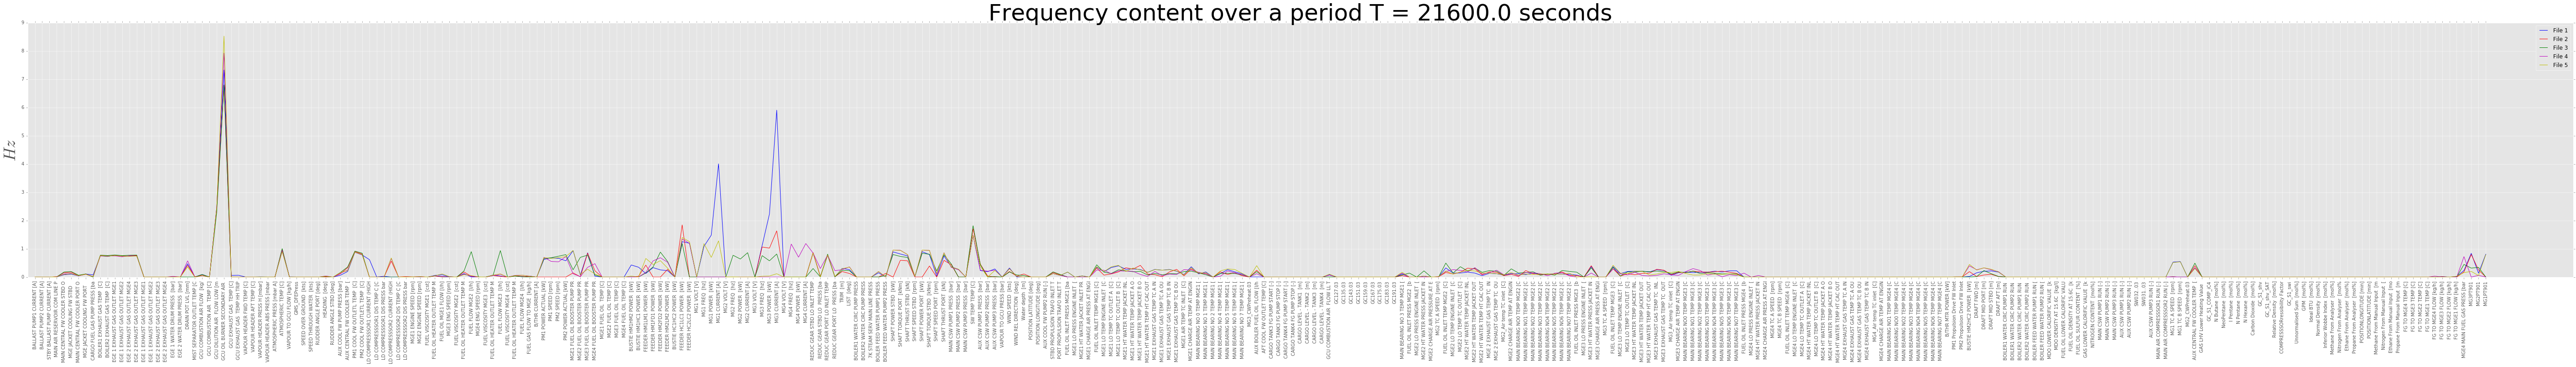

In [60]:
file_color = ['b', 'r', 'g', 'm', 'y']

fig = plt.figure(figsize=(100,10))
ax = fig.add_subplot(111)
x = np.arange(338)+1

for i,df in enumerate(freq_dfs):
    ax.plot(x, df['Frequency'], color=file_color[i], label='File '+str(i+1))

ax.set_xticks(x)
ax.set_xticklabels(df['Name'], rotation='vertical')
ax.set_title('Frequency content over a period T = '+str(dts[0])+' seconds', fontsize = 50)
ax.set_ylabel('$Hz$', fontsize = 36)
ax.legend()
    

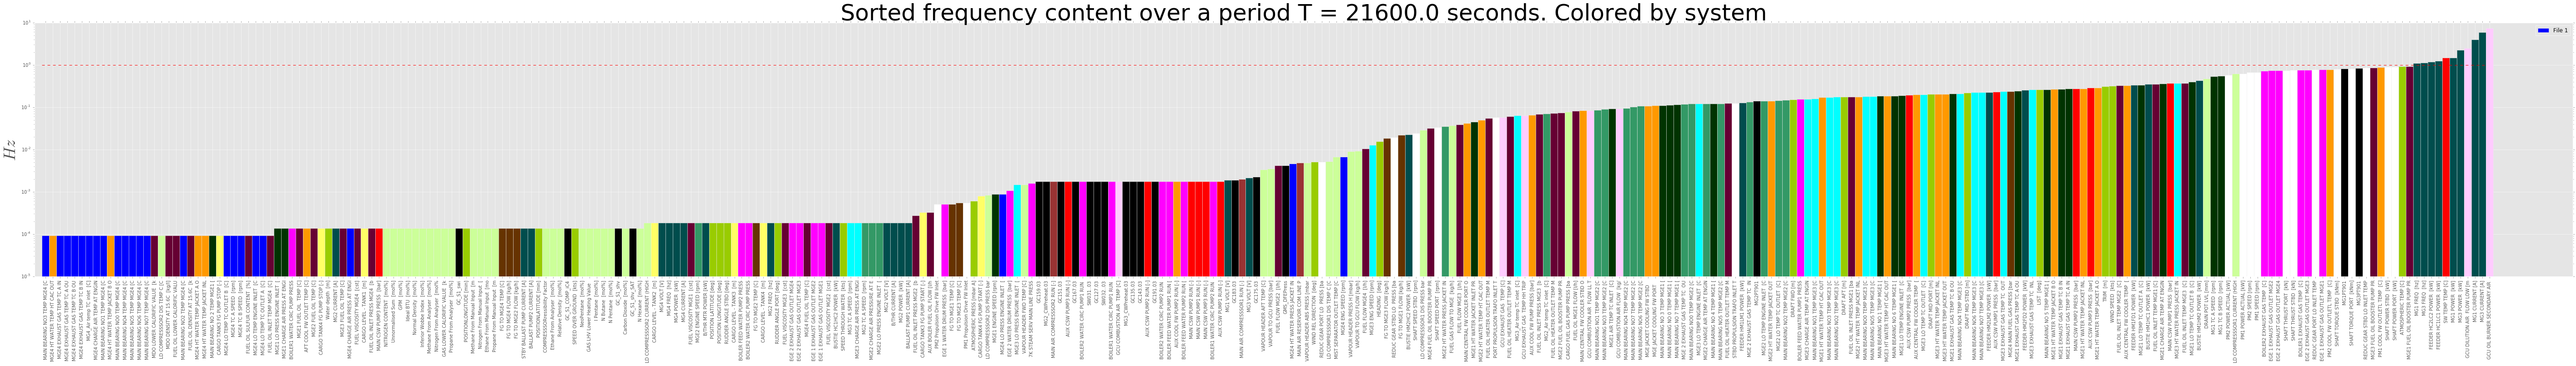

In [107]:
sys_dict = {'SEA WATER COOLING SYSTEM':'#ff0000','FRESH WATER COOLING SYSTEM':'#ff9900','NAVIGATIONAL SYSTEM':'#99cc00','MAIN GENERATOR ENGINE 1':'#003300','MAIN GENERATOR ENGINE 2':'#339966','MAIN GENERATOR ENGINE 3':'#00ffff','MAIN GENERATOR ENGINE 4':'#0000ff','EXHAUST SYSTEM':'#6600ff','STEAM SYSTEM':'#ff00ff','FUEL OIL SYSTEM':'#660033','CARGO SYSTEM':'#ffff66','FUEL GAS SYSTEM':'#663300','AIR SYSTEM':'#993333','GAS COMBUSTION UNIT':'#ffccff','GAS MANAGEMENT SYSTEM':'#ccff99','POWER MANAGEMENT SYSTEM':'#004d4d','PROPULSION SYSTEM':'#ffffff', 'N/A':'#000000'}
fig2 = plt.figure(figsize=(100,10))
ax2 = fig2.add_subplot(111)
x = np.arange(338)+1

#for i,df in enumerate(freq_dfs):
df = freq_dfs[0]
df = df.sort_values('Frequency')
sys_color = [sys_dict[s] for s in df['System'].values]
ax2.bar(x, df['Frequency'], width=1, color=sys_color, label='File 1')
ax2.plot(x,np.ones(338), '--r')

ax2.set_yscale('log')
ax2.set_xticks(x+0.5)
ax2.set_xticklabels(df['Name'], rotation='vertical')
ax2.set_title('Sorted frequency content over a period T = '+str(dts[0])+' seconds. Colored by system', fontsize = 50)
ax2.set_ylabel('$Hz$', fontsize = 36)
ax2.legend()

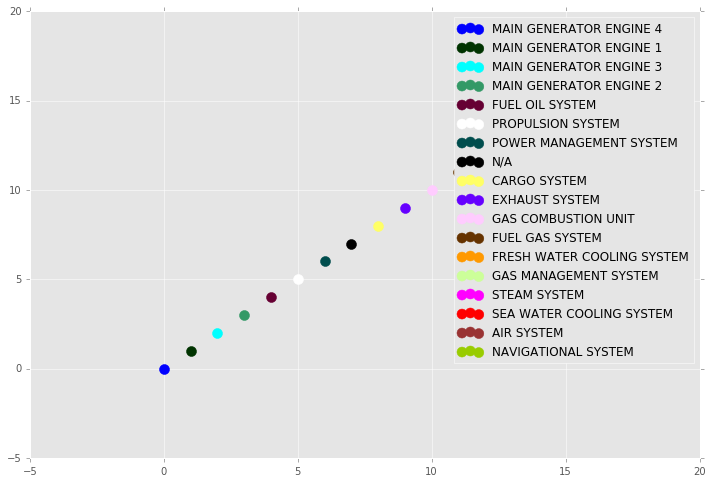

In [104]:
fig3 = plt.figure(figsize=(12,8))
ax3 = fig3.add_subplot(111)

x = np.arange(18)
y = np.arange(18)
keys = sys_dict.keys()
for i,k in enumerate(keys):
    ax3.scatter(x[i],y[i], s=100, color = sys_dict[keys[i]], label = keys[i])
    
ax3.legend()

In [111]:
fig.savefig('figures/frequency_5files.pdf',bbox_inches='tight')
fig2.savefig('figures/frequency_sorted_1file.pdf',bbox_inches='tight')
fig3.savefig('figures/system_colors.pdf')